In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from scipy.stats import wasserstein_distance, entropy
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from umap import UMAP
from matplotlib import pyplot as plt
import seaborn as sns
import faiss

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = ""
model_name = "resnet50_vicreg_ce"
ood = ""

In [3]:
# Parameters
dataset_name = "QPM2_species"
ood = "0:1"


In [4]:
# initialize data attributes and loaders
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 87612 images
Dataset type val label type: species


Loaded 21905 images
Dataset type test label type: species


Loaded 81589 images
Dataset type test label type: species


Loaded 78017 images


In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

0:1 pfcye2eb


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-pfcye2eb:best, 314.55MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:6.9


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_ftr = []
    trn_emb = []
    trn_lgt = []
    trn_tgt = []

    val_inp = []
    val_ftr = []
    val_emb = []
    val_lgt = []
    val_tgt = []

    ind_inp = []
    ind_ftr = []
    ind_emb = []
    ind_lgt = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_ftr = []
        ood_emb = []
        ood_lgt = []
        ood_tgt = []

    rnd_inp = []
    rnd_ftr = []
    rnd_emb = []
    rnd_lgt = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_ftr.extend(ftr.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_lgt.extend(lgt.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_ftr.extend(ftr.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_lgt.extend(lgt.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_ftr.extend(ftr.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_lgt.extend(lgt.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            ftr, emb, lgt = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_ftr.extend(ftr.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_lgt.extend(lgt.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_ftr.extend(ftr.detach().cpu().numpy())
        rnd_emb.extend(emb.detach().cpu().numpy())
        rnd_lgt.extend(lgt.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                                                                                                   | 0/685 [00:00<?, ?it/s]

  0%|▏                                                                                                                                          | 1/685 [00:00<07:04,  1.61it/s]

  1%|█▏                                                                                                                                         | 6/685 [00:00<01:05, 10.29it/s]

  2%|██▏                                                                                                                                       | 11/685 [00:00<00:37, 18.19it/s]

  2%|███▏                                                                                                                                      | 16/685 [00:00<00:26, 25.19it/s]

  3%|████▏                                                                                                                                     | 21/685 [00:01<00:21, 30.91it/s]

  4%|█████▏                                                                                                                                    | 26/685 [00:01<00:18, 35.68it/s]

  5%|██████▏                                                                                                                                   | 31/685 [00:01<00:16, 39.25it/s]

  5%|███████▎                                                                                                                                  | 36/685 [00:01<00:15, 41.89it/s]

  6%|████████▎                                                                                                                                 | 41/685 [00:01<00:14, 43.86it/s]

  7%|█████████▎                                                                                                                                | 46/685 [00:01<00:14, 45.27it/s]

  7%|██████████▎                                                                                                                               | 51/685 [00:01<00:13, 46.28it/s]

  8%|███████████▎                                                                                                                              | 56/685 [00:01<00:13, 47.00it/s]

  9%|████████████▎                                                                                                                             | 61/685 [00:01<00:13, 47.53it/s]

 10%|█████████████▎                                                                                                                            | 66/685 [00:01<00:12, 47.76it/s]

 10%|██████████████▎                                                                                                                           | 71/685 [00:02<00:12, 48.06it/s]

 11%|███████████████▎                                                                                                                          | 76/685 [00:02<00:12, 48.25it/s]

 12%|████████████████▎                                                                                                                         | 81/685 [00:02<00:12, 48.35it/s]

 13%|█████████████████▎                                                                                                                        | 86/685 [00:02<00:12, 48.47it/s]

 13%|██████████████████▎                                                                                                                       | 91/685 [00:02<00:12, 48.56it/s]

 14%|███████████████████▎                                                                                                                      | 96/685 [00:02<00:12, 48.63it/s]

 15%|████████████████████▏                                                                                                                    | 101/685 [00:02<00:11, 48.67it/s]

 15%|█████████████████████▏                                                                                                                   | 106/685 [00:02<00:11, 48.57it/s]

 16%|██████████████████████▏                                                                                                                  | 111/685 [00:02<00:11, 48.62it/s]

 17%|███████████████████████▏                                                                                                                 | 116/685 [00:03<00:11, 48.82it/s]

 18%|████████████████████████▏                                                                                                                | 121/685 [00:03<00:11, 48.96it/s]

 18%|█████████████████████████▏                                                                                                               | 126/685 [00:03<00:11, 48.96it/s]

 19%|██████████████████████████▏                                                                                                              | 131/685 [00:03<00:11, 49.05it/s]

 20%|███████████████████████████▏                                                                                                             | 136/685 [00:03<00:11, 49.07it/s]

 21%|████████████████████████████▏                                                                                                            | 141/685 [00:03<00:11, 49.09it/s]

 21%|█████████████████████████████▏                                                                                                           | 146/685 [00:03<00:10, 49.17it/s]

 22%|██████████████████████████████▏                                                                                                          | 151/685 [00:03<00:10, 49.23it/s]

 23%|███████████████████████████████▏                                                                                                         | 156/685 [00:03<00:10, 49.26it/s]

 24%|████████████████████████████████▏                                                                                                        | 161/685 [00:03<00:10, 49.25it/s]

 24%|█████████████████████████████████▏                                                                                                       | 166/685 [00:04<00:10, 49.24it/s]

 25%|██████████████████████████████████▏                                                                                                      | 171/685 [00:04<00:10, 49.25it/s]

 26%|███████████████████████████████████▏                                                                                                     | 176/685 [00:04<00:10, 49.27it/s]

 26%|████████████████████████████████████▏                                                                                                    | 181/685 [00:04<00:10, 49.14it/s]

 27%|█████████████████████████████████████▏                                                                                                   | 186/685 [00:04<00:10, 49.17it/s]

 28%|██████████████████████████████████████▏                                                                                                  | 191/685 [00:04<00:10, 49.21it/s]

 29%|███████████████████████████████████████▏                                                                                                 | 196/685 [00:04<00:09, 49.18it/s]

 29%|████████████████████████████████████████▏                                                                                                | 201/685 [00:04<00:09, 49.11it/s]

 30%|█████████████████████████████████████████▏                                                                                               | 206/685 [00:04<00:09, 49.16it/s]

 31%|██████████████████████████████████████████▏                                                                                              | 211/685 [00:04<00:09, 49.21it/s]

 32%|███████████████████████████████████████████▏                                                                                             | 216/685 [00:05<00:09, 49.23it/s]

 32%|████████████████████████████████████████████▏                                                                                            | 221/685 [00:05<00:09, 49.27it/s]

 33%|█████████████████████████████████████████████▏                                                                                           | 226/685 [00:05<00:09, 49.27it/s]

 34%|██████████████████████████████████████████████▏                                                                                          | 231/685 [00:05<00:09, 49.31it/s]

 34%|███████████████████████████████████████████████▏                                                                                         | 236/685 [00:05<00:09, 49.32it/s]

 35%|████████████████████████████████████████████████▏                                                                                        | 241/685 [00:05<00:09, 49.18it/s]

 36%|█████████████████████████████████████████████████▏                                                                                       | 246/685 [00:05<00:08, 49.27it/s]

 37%|██████████████████████████████████████████████████▏                                                                                      | 251/685 [00:05<00:08, 49.32it/s]

 37%|███████████████████████████████████████████████████▏                                                                                     | 256/685 [00:05<00:08, 49.37it/s]

 38%|████████████████████████████████████████████████████▏                                                                                    | 261/685 [00:05<00:08, 49.36it/s]

 39%|█████████████████████████████████████████████████████▏                                                                                   | 266/685 [00:06<00:08, 49.21it/s]

 40%|██████████████████████████████████████████████████████▏                                                                                  | 271/685 [00:06<00:08, 49.10it/s]

 40%|███████████████████████████████████████████████████████▏                                                                                 | 276/685 [00:06<00:08, 49.05it/s]

 41%|████████████████████████████████████████████████████████▏                                                                                | 281/685 [00:06<00:08, 48.93it/s]

 42%|█████████████████████████████████████████████████████████▏                                                                               | 286/685 [00:06<00:08, 48.95it/s]

 42%|██████████████████████████████████████████████████████████▏                                                                              | 291/685 [00:06<00:08, 48.93it/s]

 43%|███████████████████████████████████████████████████████████▏                                                                             | 296/685 [00:06<00:07, 48.74it/s]

 44%|████████████████████████████████████████████████████████████▏                                                                            | 301/685 [00:06<00:07, 48.76it/s]

 45%|█████████████████████████████████████████████████████████████▏                                                                           | 306/685 [00:06<00:07, 48.78it/s]

 45%|██████████████████████████████████████████████████████████████▏                                                                          | 311/685 [00:06<00:07, 48.79it/s]

 46%|███████████████████████████████████████████████████████████████▏                                                                         | 316/685 [00:07<00:07, 48.77it/s]

 47%|████████████████████████████████████████████████████████████████▏                                                                        | 321/685 [00:07<00:07, 48.76it/s]

 48%|█████████████████████████████████████████████████████████████████▏                                                                       | 326/685 [00:07<00:07, 48.76it/s]

 48%|██████████████████████████████████████████████████████████████████▏                                                                      | 331/685 [00:07<00:07, 48.78it/s]

 49%|███████████████████████████████████████████████████████████████████▏                                                                     | 336/685 [00:07<00:07, 48.79it/s]

 50%|████████████████████████████████████████████████████████████████████▏                                                                    | 341/685 [00:07<00:07, 48.67it/s]

 51%|█████████████████████████████████████████████████████████████████████▏                                                                   | 346/685 [00:07<00:06, 48.69it/s]

 51%|██████████████████████████████████████████████████████████████████████▏                                                                  | 351/685 [00:07<00:06, 48.71it/s]

 52%|███████████████████████████████████████████████████████████████████████▏                                                                 | 356/685 [00:07<00:06, 48.74it/s]

 53%|████████████████████████████████████████████████████████████████████████▏                                                                | 361/685 [00:07<00:06, 48.64it/s]

 53%|█████████████████████████████████████████████████████████████████████████▏                                                               | 366/685 [00:08<00:06, 48.70it/s]

 54%|██████████████████████████████████████████████████████████████████████████▏                                                              | 371/685 [00:08<00:06, 48.72it/s]

 55%|███████████████████████████████████████████████████████████████████████████▏                                                             | 376/685 [00:08<00:06, 48.75it/s]

 56%|████████████████████████████████████████████████████████████████████████████▏                                                            | 381/685 [00:08<00:06, 48.76it/s]

 56%|█████████████████████████████████████████████████████████████████████████████▏                                                           | 386/685 [00:08<00:06, 48.76it/s]

 57%|██████████████████████████████████████████████████████████████████████████████▏                                                          | 391/685 [00:08<00:06, 48.76it/s]

 58%|███████████████████████████████████████████████████████████████████████████████▏                                                         | 396/685 [00:08<00:05, 48.78it/s]

 59%|████████████████████████████████████████████████████████████████████████████████▏                                                        | 401/685 [00:08<00:05, 48.78it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████▏                                                       | 406/685 [00:08<00:05, 48.92it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████▏                                                      | 411/685 [00:09<00:05, 48.86it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████▏                                                     | 416/685 [00:09<00:05, 48.80it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████▏                                                    | 421/685 [00:09<00:05, 48.62it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████▏                                                   | 426/685 [00:09<00:05, 48.66it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████▏                                                  | 431/685 [00:09<00:05, 48.69it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████▏                                                 | 436/685 [00:09<00:05, 48.72it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████▏                                                | 441/685 [00:09<00:05, 48.73it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████▏                                               | 446/685 [00:09<00:04, 48.73it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████▏                                              | 451/685 [00:09<00:04, 48.72it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████▏                                             | 456/685 [00:09<00:04, 48.72it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 461/685 [00:10<00:04, 48.77it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 466/685 [00:10<00:04, 48.77it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 471/685 [00:10<00:04, 48.78it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 476/685 [00:10<00:04, 48.76it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 481/685 [00:10<00:04, 48.77it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 486/685 [00:10<00:04, 48.62it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 491/685 [00:10<00:03, 48.67it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 496/685 [00:10<00:03, 48.72it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 501/685 [00:10<00:03, 48.85it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 506/685 [00:10<00:03, 49.01it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 511/685 [00:11<00:03, 49.09it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 516/685 [00:11<00:03, 49.13it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 521/685 [00:11<00:03, 49.18it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 526/685 [00:11<00:03, 49.26it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 531/685 [00:11<00:03, 49.32it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 536/685 [00:11<00:03, 49.33it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 541/685 [00:11<00:02, 49.32it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 546/685 [00:11<00:02, 49.15it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 551/685 [00:11<00:02, 49.14it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 556/685 [00:11<00:02, 49.20it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 561/685 [00:12<00:02, 49.25it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 566/685 [00:12<00:02, 49.27it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 571/685 [00:12<00:02, 49.33it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 576/685 [00:12<00:02, 49.33it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 581/685 [00:12<00:02, 49.34it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 586/685 [00:12<00:02, 49.35it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 591/685 [00:12<00:01, 49.35it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 596/685 [00:12<00:01, 49.24it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 601/685 [00:12<00:01, 49.27it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 606/685 [00:12<00:01, 49.31it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 611/685 [00:13<00:01, 49.35it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 616/685 [00:13<00:01, 49.37it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 621/685 [00:13<00:01, 49.38it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 626/685 [00:13<00:01, 49.29it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 631/685 [00:13<00:01, 49.21it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 636/685 [00:13<00:00, 49.25it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 641/685 [00:13<00:00, 49.27it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 646/685 [00:13<00:00, 49.25it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 651/685 [00:13<00:00, 49.11it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 657/685 [00:14<00:00, 49.36it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 662/685 [00:14<00:00, 49.35it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 667/685 [00:14<00:00, 49.19it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 672/685 [00:14<00:00, 49.25it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 677/685 [00:14<00:00, 48.91it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 682/685 [00:14<00:00, 49.11it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 685/685 [00:14<00:00, 46.74it/s]

train - OK


  0%|                                                                                                                                                   | 0/172 [00:00<?, ?it/s]

  1%|▊                                                                                                                                          | 1/172 [00:00<00:29,  5.73it/s]

  3%|████▊                                                                                                                                      | 6/172 [00:00<00:06, 25.20it/s]

  6%|████████▊                                                                                                                                 | 11/172 [00:00<00:04, 34.60it/s]

  9%|████████████▊                                                                                                                             | 16/172 [00:00<00:03, 39.83it/s]

 12%|████████████████▊                                                                                                                         | 21/172 [00:00<00:03, 42.96it/s]

 15%|████████████████████▊                                                                                                                     | 26/172 [00:00<00:03, 44.99it/s]

 18%|████████████████████████▊                                                                                                                 | 31/172 [00:00<00:03, 46.24it/s]

 21%|████████████████████████████▉                                                                                                             | 36/172 [00:00<00:02, 47.19it/s]

 24%|████████████████████████████████▉                                                                                                         | 41/172 [00:00<00:02, 47.80it/s]

 27%|████████████████████████████████████▉                                                                                                     | 46/172 [00:01<00:02, 48.24it/s]

 30%|████████████████████████████████████████▉                                                                                                 | 51/172 [00:01<00:02, 48.53it/s]

 33%|████████████████████████████████████████████▉                                                                                             | 56/172 [00:01<00:02, 48.73it/s]

 35%|████████████████████████████████████████████████▉                                                                                         | 61/172 [00:01<00:02, 48.88it/s]

 38%|████████████████████████████████████████████████████▉                                                                                     | 66/172 [00:01<00:02, 49.01it/s]

 41%|████████████████████████████████████████████████████████▉                                                                                 | 71/172 [00:01<00:02, 49.07it/s]

 44%|████████████████████████████████████████████████████████████▉                                                                             | 76/172 [00:01<00:01, 49.13it/s]

 47%|████████████████████████████████████████████████████████████████▉                                                                         | 81/172 [00:01<00:01, 49.05it/s]

 50%|█████████████████████████████████████████████████████████████████████                                                                     | 86/172 [00:01<00:01, 48.95it/s]

 53%|█████████████████████████████████████████████████████████████████████████                                                                 | 91/172 [00:02<00:01, 48.82it/s]

 56%|█████████████████████████████████████████████████████████████████████████████                                                             | 96/172 [00:02<00:01, 48.91it/s]

 59%|████████████████████████████████████████████████████████████████████████████████▍                                                        | 101/172 [00:02<00:01, 49.03it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████▍                                                    | 106/172 [00:02<00:01, 49.08it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████▍                                                | 111/172 [00:02<00:01, 49.14it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 116/172 [00:02<00:01, 49.18it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 121/172 [00:02<00:01, 49.21it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 126/172 [00:02<00:00, 49.27it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 131/172 [00:02<00:00, 49.20it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 136/172 [00:02<00:00, 49.07it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 141/172 [00:03<00:00, 48.98it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 146/172 [00:03<00:00, 48.76it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 151/172 [00:03<00:00, 48.74it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 156/172 [00:03<00:00, 48.74it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 161/172 [00:03<00:00, 48.74it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 166/172 [00:03<00:00, 48.74it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 171/172 [00:03<00:00, 48.90it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 172/172 [00:03<00:00, 46.01it/s]

val - OK


  0%|                                                                                                                                                   | 0/638 [00:00<?, ?it/s]

  0%|▏                                                                                                                                          | 1/638 [00:00<01:54,  5.55it/s]

  1%|█▎                                                                                                                                         | 6/638 [00:00<00:25, 24.83it/s]

  2%|██▍                                                                                                                                       | 11/638 [00:00<00:18, 34.33it/s]

  3%|███▍                                                                                                                                      | 16/638 [00:00<00:15, 39.60it/s]

  3%|████▌                                                                                                                                     | 21/638 [00:00<00:14, 42.94it/s]

  4%|█████▌                                                                                                                                    | 26/638 [00:00<00:13, 44.95it/s]

  5%|██████▋                                                                                                                                   | 31/638 [00:00<00:13, 46.23it/s]

  6%|███████▊                                                                                                                                  | 36/638 [00:00<00:12, 47.07it/s]

  6%|████████▊                                                                                                                                 | 41/638 [00:00<00:12, 47.66it/s]

  7%|█████████▉                                                                                                                                | 46/638 [00:01<00:12, 48.03it/s]

  8%|███████████                                                                                                                               | 51/638 [00:01<00:12, 48.30it/s]

  9%|████████████                                                                                                                              | 56/638 [00:01<00:12, 48.43it/s]

 10%|█████████████▏                                                                                                                            | 61/638 [00:01<00:11, 48.59it/s]

 10%|██████████████▎                                                                                                                           | 66/638 [00:01<00:11, 48.70it/s]

 11%|███████████████▎                                                                                                                          | 71/638 [00:01<00:11, 48.65it/s]

 12%|████████████████▍                                                                                                                         | 76/638 [00:01<00:11, 48.75it/s]

 13%|█████████████████▌                                                                                                                        | 81/638 [00:01<00:11, 48.80it/s]

 13%|██████████████████▌                                                                                                                       | 86/638 [00:01<00:11, 48.80it/s]

 14%|███████████████████▋                                                                                                                      | 91/638 [00:02<00:11, 48.84it/s]

 15%|████████████████████▊                                                                                                                     | 96/638 [00:02<00:11, 48.86it/s]

 16%|█████████████████████▋                                                                                                                   | 101/638 [00:02<00:10, 48.89it/s]

 17%|██████████████████████▊                                                                                                                  | 106/638 [00:02<00:10, 48.87it/s]

 17%|███████████████████████▊                                                                                                                 | 111/638 [00:02<00:10, 48.75it/s]

 18%|████████████████████████▉                                                                                                                | 116/638 [00:02<00:10, 48.76it/s]

 19%|█████████████████████████▉                                                                                                               | 121/638 [00:02<00:10, 48.79it/s]

 20%|███████████████████████████                                                                                                              | 126/638 [00:02<00:10, 48.85it/s]

 21%|████████████████████████████▏                                                                                                            | 131/638 [00:02<00:10, 48.75it/s]

 21%|█████████████████████████████▏                                                                                                           | 136/638 [00:02<00:10, 48.80it/s]

 22%|██████████████████████████████▎                                                                                                          | 141/638 [00:03<00:10, 48.82it/s]

 23%|███████████████████████████████▎                                                                                                         | 146/638 [00:03<00:10, 48.86it/s]

 24%|████████████████████████████████▍                                                                                                        | 151/638 [00:03<00:09, 48.91it/s]

 24%|█████████████████████████████████▍                                                                                                       | 156/638 [00:03<00:09, 48.91it/s]

 25%|██████████████████████████████████▌                                                                                                      | 161/638 [00:03<00:09, 48.91it/s]

 26%|███████████████████████████████████▋                                                                                                     | 166/638 [00:03<00:09, 48.89it/s]

 27%|████████████████████████████████████▋                                                                                                    | 171/638 [00:03<00:09, 48.91it/s]

 28%|█████████████████████████████████████▊                                                                                                   | 176/638 [00:03<00:09, 48.92it/s]

 28%|██████████████████████████████████████▊                                                                                                  | 181/638 [00:03<00:09, 48.91it/s]

 29%|███████████████████████████████████████▉                                                                                                 | 186/638 [00:03<00:09, 48.78it/s]

 30%|█████████████████████████████████████████                                                                                                | 191/638 [00:04<00:09, 48.81it/s]

 31%|██████████████████████████████████████████                                                                                               | 196/638 [00:04<00:09, 48.84it/s]

 32%|███████████████████████████████████████████▏                                                                                             | 201/638 [00:04<00:08, 48.90it/s]

 32%|████████████████████████████████████████████▏                                                                                            | 206/638 [00:04<00:08, 48.92it/s]

 33%|█████████████████████████████████████████████▎                                                                                           | 211/638 [00:04<00:08, 48.93it/s]

 34%|██████████████████████████████████████████████▍                                                                                          | 216/638 [00:04<00:08, 48.94it/s]

 35%|███████████████████████████████████████████████▍                                                                                         | 221/638 [00:04<00:08, 48.91it/s]

 35%|████████████████████████████████████████████████▌                                                                                        | 226/638 [00:04<00:08, 48.93it/s]

 36%|█████████████████████████████████████████████████▌                                                                                       | 231/638 [00:04<00:08, 48.94it/s]

 37%|██████████████████████████████████████████████████▋                                                                                      | 236/638 [00:04<00:08, 48.96it/s]

 38%|███████████████████████████████████████████████████▊                                                                                     | 241/638 [00:05<00:08, 48.93it/s]

 39%|████████████████████████████████████████████████████▊                                                                                    | 246/638 [00:05<00:08, 48.79it/s]

 39%|█████████████████████████████████████████████████████▉                                                                                   | 251/638 [00:05<00:07, 48.88it/s]

 40%|██████████████████████████████████████████████████████▉                                                                                  | 256/638 [00:05<00:07, 49.04it/s]

 41%|████████████████████████████████████████████████████████                                                                                 | 261/638 [00:05<00:07, 49.05it/s]

 42%|█████████████████████████████████████████████████████████                                                                                | 266/638 [00:05<00:07, 49.03it/s]

 42%|██████████████████████████████████████████████████████████▏                                                                              | 271/638 [00:05<00:07, 49.00it/s]

 43%|███████████████████████████████████████████████████████████▎                                                                             | 276/638 [00:05<00:07, 49.01it/s]

 44%|████████████████████████████████████████████████████████████▎                                                                            | 281/638 [00:05<00:07, 48.99it/s]

 45%|█████████████████████████████████████████████████████████████▍                                                                           | 286/638 [00:06<00:07, 49.00it/s]

 46%|██████████████████████████████████████████████████████████████▍                                                                          | 291/638 [00:06<00:07, 48.98it/s]

 46%|███████████████████████████████████████████████████████████████▌                                                                         | 296/638 [00:06<00:06, 49.00it/s]

 47%|████████████████████████████████████████████████████████████████▋                                                                        | 301/638 [00:06<00:06, 49.05it/s]

 48%|█████████████████████████████████████████████████████████████████▋                                                                       | 306/638 [00:06<00:06, 49.03it/s]

 49%|██████████████████████████████████████████████████████████████████▊                                                                      | 311/638 [00:06<00:06, 49.21it/s]

 50%|███████████████████████████████████████████████████████████████████▊                                                                     | 316/638 [00:06<00:06, 49.30it/s]

 50%|████████████████████████████████████████████████████████████████████▉                                                                    | 321/638 [00:06<00:06, 49.36it/s]

 51%|██████████████████████████████████████████████████████████████████████                                                                   | 326/638 [00:06<00:06, 49.45it/s]

 52%|███████████████████████████████████████████████████████████████████████                                                                  | 331/638 [00:06<00:06, 49.50it/s]

 53%|████████████████████████████████████████████████████████████████████████▏                                                                | 336/638 [00:07<00:06, 49.53it/s]

 53%|█████████████████████████████████████████████████████████████████████████▏                                                               | 341/638 [00:07<00:05, 49.56it/s]

 54%|██████████████████████████████████████████████████████████████████████████▎                                                              | 346/638 [00:07<00:05, 49.55it/s]

 55%|███████████████████████████████████████████████████████████████████████████▎                                                             | 351/638 [00:07<00:05, 49.53it/s]

 56%|████████████████████████████████████████████████████████████████████████████▍                                                            | 356/638 [00:07<00:05, 49.54it/s]

 57%|█████████████████████████████████████████████████████████████████████████████▌                                                           | 361/638 [00:07<00:05, 49.61it/s]

 57%|██████████████████████████████████████████████████████████████████████████████▌                                                          | 366/638 [00:07<00:05, 49.54it/s]

 58%|███████████████████████████████████████████████████████████████████████████████▋                                                         | 371/638 [00:07<00:05, 49.33it/s]

 59%|████████████████████████████████████████████████████████████████████████████████▋                                                        | 376/638 [00:07<00:05, 49.24it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████▊                                                       | 381/638 [00:07<00:05, 49.35it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████▉                                                      | 386/638 [00:08<00:05, 49.37it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████▉                                                     | 391/638 [00:08<00:04, 49.44it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████                                                    | 396/638 [00:08<00:04, 49.50it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████                                                   | 401/638 [00:08<00:04, 49.49it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████▏                                                 | 406/638 [00:08<00:04, 49.50it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████▎                                                | 411/638 [00:08<00:04, 49.52it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████▎                                               | 416/638 [00:08<00:04, 49.47it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████▍                                              | 421/638 [00:08<00:04, 49.40it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████▍                                             | 426/638 [00:08<00:04, 49.44it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 431/638 [00:08<00:04, 49.46it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 436/638 [00:09<00:04, 49.32it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 441/638 [00:09<00:03, 49.35it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 446/638 [00:09<00:03, 49.34it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 451/638 [00:09<00:03, 49.29it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 456/638 [00:09<00:03, 49.35it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 461/638 [00:09<00:03, 49.42it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 466/638 [00:09<00:03, 49.45it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 471/638 [00:09<00:03, 49.44it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 476/638 [00:09<00:03, 49.42it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 481/638 [00:09<00:03, 49.43it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 486/638 [00:10<00:03, 49.33it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 491/638 [00:10<00:02, 49.37it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 496/638 [00:10<00:02, 49.39it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 501/638 [00:10<00:02, 49.40it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 506/638 [00:10<00:02, 49.40it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 511/638 [00:10<00:02, 49.41it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 516/638 [00:10<00:02, 49.51it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 521/638 [00:10<00:02, 49.50it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 526/638 [00:10<00:02, 49.51it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 531/638 [00:10<00:02, 49.48it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 536/638 [00:11<00:02, 49.52it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 541/638 [00:11<00:01, 49.52it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 546/638 [00:11<00:01, 49.50it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 551/638 [00:11<00:01, 49.38it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 556/638 [00:11<00:01, 49.41it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 561/638 [00:11<00:01, 49.43it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 566/638 [00:11<00:01, 49.46it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 571/638 [00:11<00:01, 49.51it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 576/638 [00:11<00:01, 49.46it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 581/638 [00:11<00:01, 49.47it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 586/638 [00:12<00:01, 49.51it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 591/638 [00:12<00:00, 49.52it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 596/638 [00:12<00:00, 49.54it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 601/638 [00:12<00:00, 49.44it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 606/638 [00:12<00:00, 49.42it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 611/638 [00:12<00:00, 49.44it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 616/638 [00:12<00:00, 49.46it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 621/638 [00:12<00:00, 49.45it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 626/638 [00:12<00:00, 49.50it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 631/638 [00:12<00:00, 49.54it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 636/638 [00:13<00:00, 49.64it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 638/638 [00:13<00:00, 48.21it/s]

test InD - OK


  0%|                                                                                                                                                   | 0/610 [00:00<?, ?it/s]

  0%|▏                                                                                                                                          | 1/610 [00:00<02:14,  4.52it/s]

  1%|█▎                                                                                                                                         | 6/610 [00:00<00:27, 22.03it/s]

  2%|██▍                                                                                                                                       | 11/610 [00:00<00:18, 31.83it/s]

  3%|███▌                                                                                                                                      | 16/610 [00:00<00:15, 37.74it/s]

  3%|████▊                                                                                                                                     | 21/610 [00:00<00:14, 41.33it/s]

  4%|█████▉                                                                                                                                    | 26/610 [00:00<00:13, 43.84it/s]

  5%|███████                                                                                                                                   | 31/610 [00:00<00:12, 45.43it/s]

  6%|████████▏                                                                                                                                 | 36/610 [00:00<00:12, 46.64it/s]

  7%|█████████▎                                                                                                                                | 41/610 [00:01<00:11, 47.49it/s]

  8%|██████████▍                                                                                                                               | 46/610 [00:01<00:11, 48.02it/s]

  8%|███████████▌                                                                                                                              | 51/610 [00:01<00:11, 48.40it/s]

  9%|████████████▋                                                                                                                             | 56/610 [00:01<00:11, 48.65it/s]

 10%|█████████████▊                                                                                                                            | 61/610 [00:01<00:11, 48.85it/s]

 11%|██████████████▉                                                                                                                           | 66/610 [00:01<00:11, 48.97it/s]

 12%|████████████████                                                                                                                          | 71/610 [00:01<00:10, 49.05it/s]

 12%|█████████████████▏                                                                                                                        | 76/610 [00:01<00:10, 49.11it/s]

 13%|██████████████████▎                                                                                                                       | 81/610 [00:01<00:10, 49.21it/s]

 14%|███████████████████▍                                                                                                                      | 86/610 [00:01<00:10, 49.10it/s]

 15%|████████████████████▌                                                                                                                     | 91/610 [00:02<00:10, 49.14it/s]

 16%|█████████████████████▋                                                                                                                    | 96/610 [00:02<00:10, 49.15it/s]

 17%|██████████████████████▋                                                                                                                  | 101/610 [00:02<00:10, 49.08it/s]

 17%|███████████████████████▊                                                                                                                 | 106/610 [00:02<00:10, 49.13it/s]

 18%|████████████████████████▉                                                                                                                | 111/610 [00:02<00:10, 49.20it/s]

 19%|██████████████████████████                                                                                                               | 116/610 [00:02<00:10, 49.27it/s]

 20%|███████████████████████████▏                                                                                                             | 121/610 [00:02<00:09, 49.31it/s]

 21%|████████████████████████████▎                                                                                                            | 126/610 [00:02<00:09, 49.30it/s]

 21%|█████████████████████████████▍                                                                                                           | 131/610 [00:02<00:09, 49.31it/s]

 22%|██████████████████████████████▌                                                                                                          | 136/610 [00:02<00:09, 49.32it/s]

 23%|███████████████████████████████▋                                                                                                         | 141/610 [00:03<00:09, 49.33it/s]

 24%|████████████████████████████████▊                                                                                                        | 146/610 [00:03<00:09, 49.21it/s]

 25%|█████████████████████████████████▉                                                                                                       | 151/610 [00:03<00:09, 49.26it/s]

 26%|███████████████████████████████████                                                                                                      | 156/610 [00:03<00:09, 49.29it/s]

 26%|████████████████████████████████████▏                                                                                                    | 161/610 [00:03<00:09, 49.32it/s]

 27%|█████████████████████████████████████▎                                                                                                   | 166/610 [00:03<00:08, 49.34it/s]

 28%|██████████████████████████████████████▍                                                                                                  | 171/610 [00:03<00:08, 49.35it/s]

 29%|███████████████████████████████████████▌                                                                                                 | 176/610 [00:03<00:08, 49.31it/s]

 30%|████████████████████████████████████████▋                                                                                                | 181/610 [00:03<00:08, 49.32it/s]

 30%|█████████████████████████████████████████▊                                                                                               | 186/610 [00:03<00:08, 49.36it/s]

 31%|██████████████████████████████████████████▉                                                                                              | 191/610 [00:04<00:08, 49.37it/s]

 32%|████████████████████████████████████████████                                                                                             | 196/610 [00:04<00:08, 49.36it/s]

 33%|█████████████████████████████████████████████▏                                                                                           | 201/610 [00:04<00:08, 49.19it/s]

 34%|██████████████████████████████████████████████▎                                                                                          | 206/610 [00:04<00:08, 49.09it/s]

 35%|███████████████████████████████████████████████▍                                                                                         | 211/610 [00:04<00:08, 49.17it/s]

 35%|████████████████████████████████████████████████▌                                                                                        | 216/610 [00:04<00:08, 49.23it/s]

 36%|█████████████████████████████████████████████████▋                                                                                       | 221/610 [00:04<00:07, 49.26it/s]

 37%|██████████████████████████████████████████████████▊                                                                                      | 226/610 [00:04<00:07, 49.26it/s]

 38%|███████████████████████████████████████████████████▉                                                                                     | 231/610 [00:04<00:07, 49.11it/s]

 39%|█████████████████████████████████████████████████████                                                                                    | 236/610 [00:04<00:07, 49.02it/s]

 40%|██████████████████████████████████████████████████████▏                                                                                  | 241/610 [00:05<00:07, 48.97it/s]

 40%|███████████████████████████████████████████████████████▏                                                                                 | 246/610 [00:05<00:07, 48.92it/s]

 41%|████████████████████████████████████████████████████████▎                                                                                | 251/610 [00:05<00:07, 48.88it/s]

 42%|█████████████████████████████████████████████████████████▍                                                                               | 256/610 [00:05<00:07, 48.66it/s]

 43%|██████████████████████████████████████████████████████████▌                                                                              | 261/610 [00:05<00:07, 48.71it/s]

 44%|███████████████████████████████████████████████████████████▋                                                                             | 266/610 [00:05<00:07, 48.74it/s]

 44%|████████████████████████████████████████████████████████████▊                                                                            | 271/610 [00:05<00:06, 48.77it/s]

 45%|█████████████████████████████████████████████████████████████▉                                                                           | 276/610 [00:05<00:06, 48.79it/s]

 46%|███████████████████████████████████████████████████████████████                                                                          | 281/610 [00:05<00:06, 48.66it/s]

 47%|████████████████████████████████████████████████████████████████▏                                                                        | 286/610 [00:06<00:06, 48.75it/s]

 48%|█████████████████████████████████████████████████████████████████▎                                                                       | 291/610 [00:06<00:06, 48.77it/s]

 49%|██████████████████████████████████████████████████████████████████▍                                                                      | 296/610 [00:06<00:06, 48.77it/s]

 49%|███████████████████████████████████████████████████████████████████▌                                                                     | 301/610 [00:06<00:06, 48.75it/s]

 50%|████████████████████████████████████████████████████████████████████▋                                                                    | 306/610 [00:06<00:06, 48.74it/s]

 51%|█████████████████████████████████████████████████████████████████████▊                                                                   | 311/610 [00:06<00:06, 48.75it/s]

 52%|██████████████████████████████████████████████████████████████████████▉                                                                  | 316/610 [00:06<00:06, 48.64it/s]

 53%|████████████████████████████████████████████████████████████████████████                                                                 | 321/610 [00:06<00:05, 48.65it/s]

 53%|█████████████████████████████████████████████████████████████████████████▏                                                               | 326/610 [00:06<00:05, 48.69it/s]

 54%|██████████████████████████████████████████████████████████████████████████▎                                                              | 331/610 [00:06<00:05, 48.66it/s]

 55%|███████████████████████████████████████████████████████████████████████████▍                                                             | 336/610 [00:07<00:05, 48.59it/s]

 56%|████████████████████████████████████████████████████████████████████████████▌                                                            | 341/610 [00:07<00:05, 48.45it/s]

 57%|█████████████████████████████████████████████████████████████████████████████▋                                                           | 346/610 [00:07<00:05, 48.55it/s]

 58%|██████████████████████████████████████████████████████████████████████████████▊                                                          | 351/610 [00:07<00:05, 48.63it/s]

 58%|███████████████████████████████████████████████████████████████████████████████▉                                                         | 356/610 [00:07<00:05, 48.69it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████                                                        | 361/610 [00:07<00:05, 48.73it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████▏                                                      | 366/610 [00:07<00:05, 48.76it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████▎                                                     | 371/610 [00:07<00:04, 48.77it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████▍                                                    | 376/610 [00:07<00:04, 48.64it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████▌                                                   | 381/610 [00:07<00:04, 48.69it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████▋                                                  | 386/610 [00:08<00:04, 48.70it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████▊                                                 | 391/610 [00:08<00:04, 48.71it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████▉                                                | 396/610 [00:08<00:04, 48.75it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████                                               | 401/610 [00:08<00:04, 48.77it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████▏                                             | 406/610 [00:08<00:04, 48.85it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 411/610 [00:08<00:04, 48.81it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 416/610 [00:08<00:03, 48.77it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 421/610 [00:08<00:03, 48.79it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 426/610 [00:08<00:03, 48.76it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 431/610 [00:09<00:03, 48.63it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 436/610 [00:09<00:03, 48.64it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████                                      | 441/610 [00:09<00:03, 48.61it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 446/610 [00:09<00:03, 48.67it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 451/610 [00:09<00:03, 48.73it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 456/610 [00:09<00:03, 48.71it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 461/610 [00:09<00:03, 48.79it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 466/610 [00:09<00:02, 48.77it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 471/610 [00:09<00:02, 48.80it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 476/610 [00:09<00:02, 48.81it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 481/610 [00:10<00:02, 48.80it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 486/610 [00:10<00:02, 48.78it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 491/610 [00:10<00:02, 48.56it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 496/610 [00:10<00:02, 48.47it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 501/610 [00:10<00:02, 48.59it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 506/610 [00:10<00:02, 48.67it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 511/610 [00:10<00:02, 48.65it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 516/610 [00:10<00:01, 48.74it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 521/610 [00:10<00:01, 48.76it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 526/610 [00:10<00:01, 48.78it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 531/610 [00:11<00:01, 48.80it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 536/610 [00:11<00:01, 48.81it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 541/610 [00:11<00:01, 48.80it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 546/610 [00:11<00:01, 48.65it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 551/610 [00:11<00:01, 48.71it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 556/610 [00:11<00:01, 48.68it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 561/610 [00:11<00:01, 48.71it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 566/610 [00:11<00:00, 48.72it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 571/610 [00:11<00:00, 48.75it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 576/610 [00:11<00:00, 48.73it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 581/610 [00:12<00:00, 48.75it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 586/610 [00:12<00:00, 48.78it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 591/610 [00:12<00:00, 48.88it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 596/610 [00:12<00:00, 48.70it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 601/610 [00:12<00:00, 48.91it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 606/610 [00:12<00:00, 49.13it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 610/610 [00:12<00:00, 47.76it/s]

test OoD - OK


  0%|                                                                                                                                                   | 0/100 [00:00<?, ?it/s]

  6%|████████▎                                                                                                                                  | 6/100 [00:00<00:01, 53.69it/s]

 12%|████████████████▌                                                                                                                         | 12/100 [00:00<00:01, 52.38it/s]

 18%|████████████████████████▊                                                                                                                 | 18/100 [00:00<00:01, 52.03it/s]

 24%|█████████████████████████████████                                                                                                         | 24/100 [00:00<00:01, 51.93it/s]

 30%|█████████████████████████████████████████▍                                                                                                | 30/100 [00:00<00:01, 51.73it/s]

 36%|█████████████████████████████████████████████████▋                                                                                        | 36/100 [00:00<00:01, 51.76it/s]

 42%|█████████████████████████████████████████████████████████▉                                                                                | 42/100 [00:00<00:01, 51.79it/s]

 48%|██████████████████████████████████████████████████████████████████▏                                                                       | 48/100 [00:00<00:01, 51.82it/s]

 54%|██████████████████████████████████████████████████████████████████████████▌                                                               | 54/100 [00:01<00:00, 51.72it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████▊                                                       | 60/100 [00:01<00:00, 51.77it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████                                               | 66/100 [00:01<00:00, 51.81it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 72/100 [00:01<00:00, 51.86it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 78/100 [00:01<00:00, 51.76it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 84/100 [00:01<00:00, 51.81it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 90/100 [00:01<00:00, 51.86it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 96/100 [00:01<00:00, 51.86it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 51.86it/s]

test RnD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_ftr = np.array(trn_ftr).squeeze()
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt) 

val_inp = np.array(val_inp)
val_ftr = np.array(val_ftr).squeeze()
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_ftr = np.array(ind_ftr).squeeze()
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_ftr = np.array(ood_ftr).squeeze()
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_ftr = np.array(rnd_ftr).squeeze()
rnd_emb = np.array(rnd_emb).squeeze()
rnd_lgt = np.array(rnd_lgt).squeeze()

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_ftr.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_ftr.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_ftr.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_ftr.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_ftr.shape, rnd_emb.shape, rnd_lgt.shape)

(87612, 3, 64, 64) (87612, 2048) (87612, 512) (87612, 2) (87612,)
(21905, 3, 64, 64) (21905, 2048) (21905, 512) (21905, 2) (21905,)
(81589, 3, 64, 64) (81589, 2048) (81589, 512) (81589, 2) (81589,)
(78017, 3, 64, 64) (78017, 2048) (78017, 512) (78017, 2) (78017,)
(12800, 3, 64, 64) (12800, 2048) (12800, 512) (12800, 2)


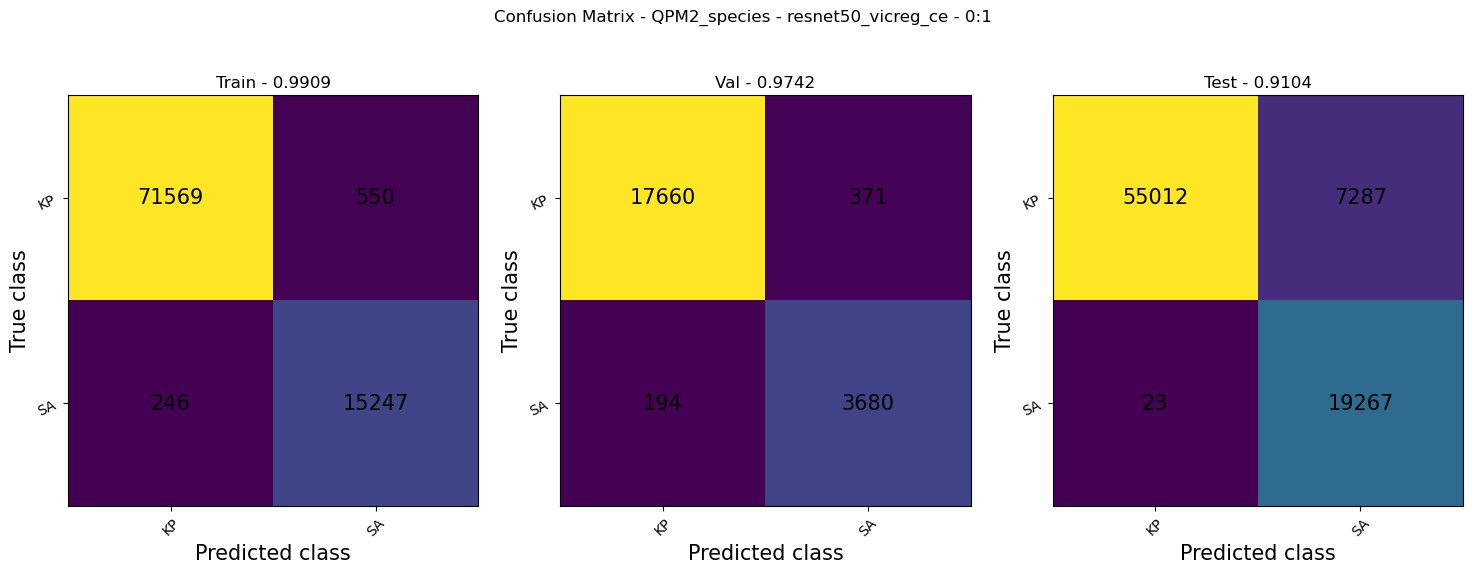

In [11]:
# compute test set accuracy
from torchmetrics import Accuracy, ConfusionMatrix

K = len(config.labels) - len(config.ood)
accuracy = Accuracy(task="multiclass", num_classes=K, top_k=1)

train_acc = accuracy(torch.as_tensor(trn_lgt.argmax(-1)), torch.as_tensor(trn_tgt)).item()
accuracy.reset()
val_acc = accuracy(torch.as_tensor(val_lgt.argmax(-1)), torch.as_tensor(val_tgt)).item()
accuracy.reset()
test_acc = accuracy(torch.as_tensor(ind_lgt.argmax(-1)), torch.as_tensor(ind_tgt)).item()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
confmat = ConfusionMatrix(task="multiclass", num_classes=K)
cm_trn = confmat(torch.as_tensor(trn_lgt.argmax(-1)), torch.as_tensor(trn_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax1)
ax1.set_title(f"Train - {train_acc:.4f}")
confmat.reset()
cm_val = confmat(torch.as_tensor(val_lgt.argmax(-1)), torch.as_tensor(val_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax2)
ax2.set_title(f"Val - {val_acc:.4f}")
confmat.reset()
cm_tst = confmat(torch.as_tensor(ind_lgt.argmax(-1)), torch.as_tensor(ind_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax3)
ax3.set_title(f"Test - {test_acc:.4f}")

plt.suptitle(f"Confusion Matrix - {dataset_name} - {model_name} - {ood_str}")
plt.show()

In [12]:
# create 2d embeddings
n = ind_ftr.shape[0]
all_ftr = ind_ftr
all_lgt = ind_lgt
if ood_str:
    all_ftr = np.concatenate([all_ftr, ood_ftr], axis=0)
    all_lgt = np.concatenate([all_lgt, ood_lgt], axis=0)

umap = UMAP(n_components=2, random_state=42)
all_ftr2d = umap.fit_transform(all_ftr)
ind_ftr2d = np.array(all_ftr2d[:n], order='C').astype(np.float32)
ood_ftr2d = np.array(all_ftr2d[n:], order='C').astype(np.float32)
print(ind_ftr2d.shape, ood_ftr2d.shape)

if all_lgt.shape[-1] > 2:
    umap = UMAP(n_components=2, random_state=42)
    lgt2d = umap.fit_transform(all_lgt)
else:
    lgt2d = all_lgt
ind_lgt2d = np.array(lgt2d[:n], order='C').astype(np.float32)
ood_lgt2d = np.array(lgt2d[n:], order='C').astype(np.float32)
print(ind_lgt2d.shape, ood_lgt2d.shape)

/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(81589, 2) (78017, 2)
(81589, 2) (78017, 2)


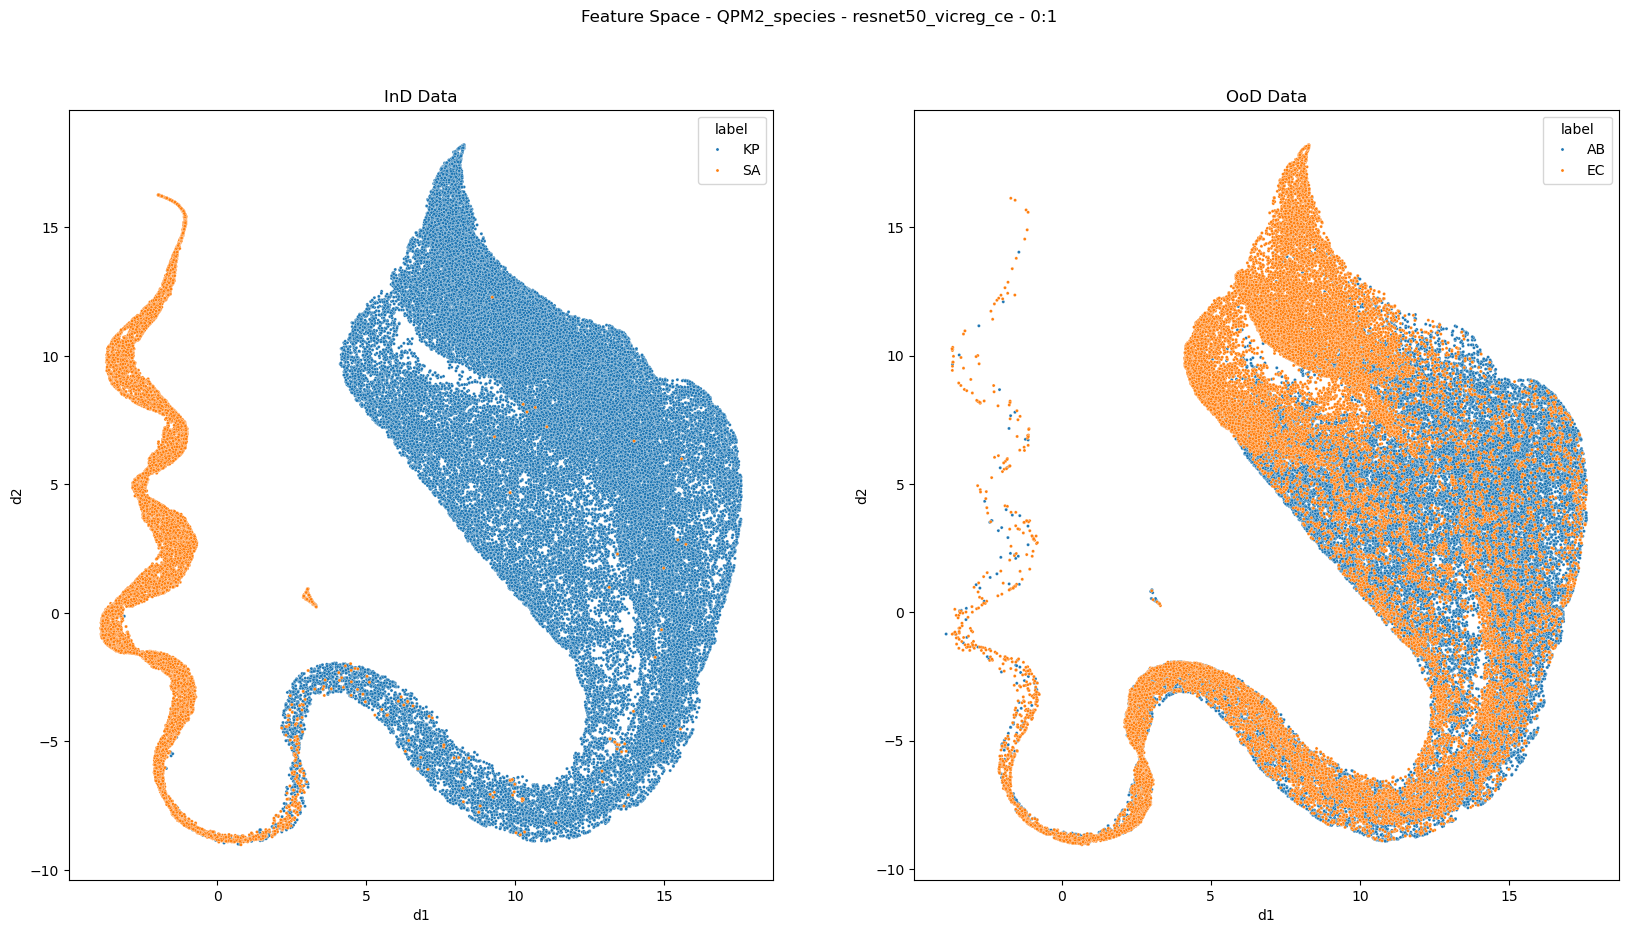

In [13]:
# plot feature space
df_ftr2d = pd.DataFrame()
d1, d2 = ind_ftr2d.T
df_ftr2d = pd.concat([df_ftr2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_ftr2d.T
    df_ftr2d = pd.concat([df_ftr2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_ftr2d[(df_ftr2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_ftr2d[(df_ftr2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

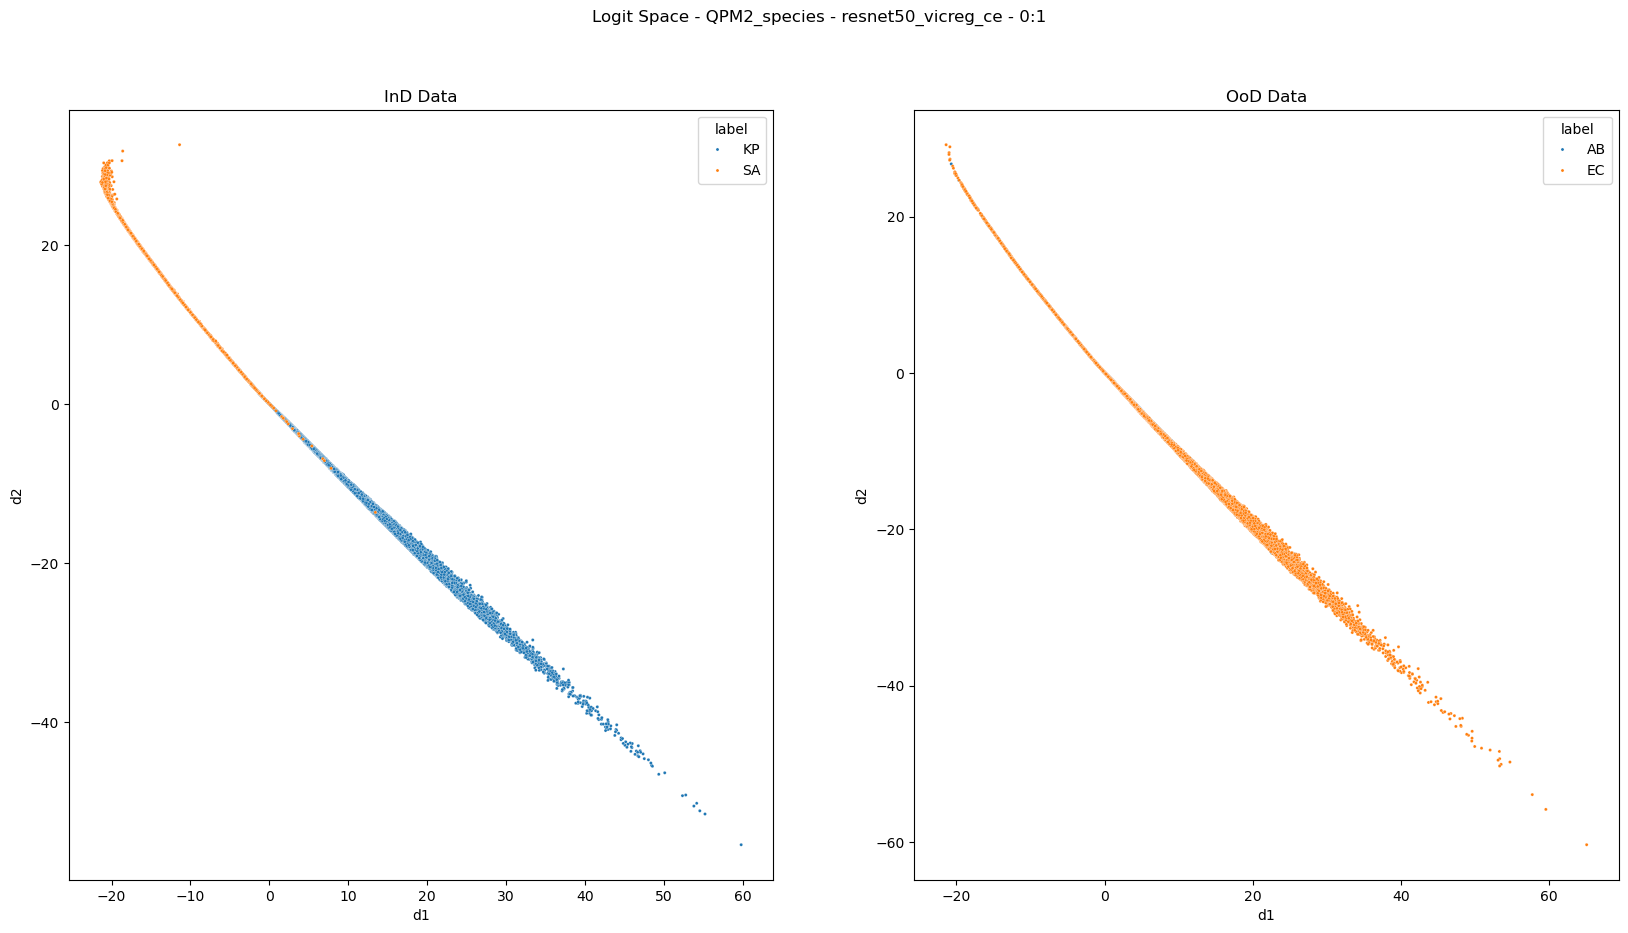

In [14]:
# plot logit space
df_lgt2d = pd.DataFrame()
d1, d2 = ind_lgt2d.T
df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt2d.T
    df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

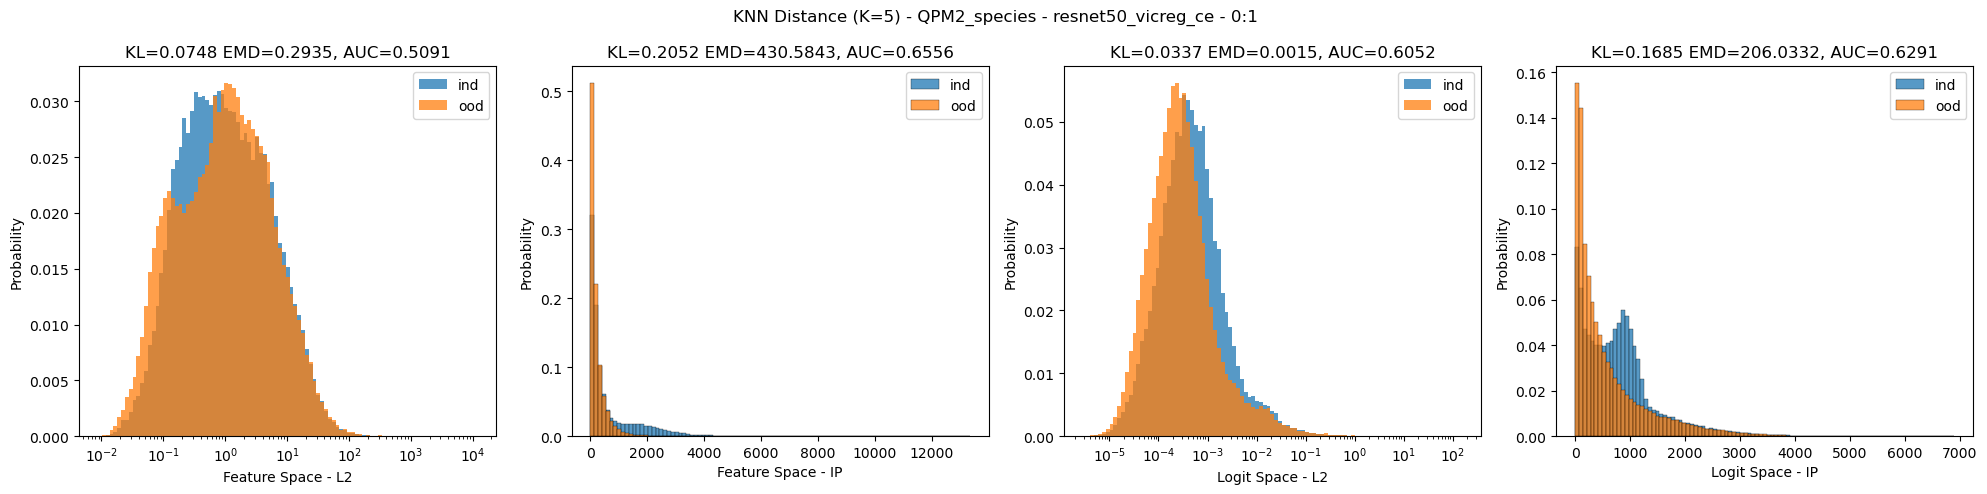

In [15]:
# plot knn distance from ind/ood to val data
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"KNN Distance (K=5) - {dataset_name} - {model_name} - {ood_str}")

def plot_knn_dists(index_fn, ax, idx_data, ind_data, ood_data=None, k=5, scale="linspace"):
    index = index_fn(idx_data.shape[-1])
    index.add(idx_data)
    Di = index.search(ind_data, k)[0].mean(-1)
    D = [Di]
    T = [[0] * Di.shape[0]]
    if ood_str:
        Do = index.search(ood_data, k)[0].mean(-1)
        D.append(Do)
        T.append([1] * Do.shape[0]) 
    D = np.concatenate(D, axis=0)
    T = np.concatenate(T, axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    prefix = ""
    if ood_str:
        Ci = np.histogram(Di, bins, density=True)[0]
        Co = np.histogram(Do, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(Do, Di)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
        ax.set_title(f"KL={kld:.4f} EMD={emd:.4f}, AUC={auc:.4f}")
    if scale == "logspace":
        ax.set_xscale('log')
    ax.legend()

plot_knn_dists(faiss.IndexFlatL2, axs[0], val_ftr, ind_ftr, ood_ftr if ood_str else None, scale="logspace")
axs[0].set_xlabel("Feature Space - L2")
plot_knn_dists(faiss.IndexFlatIP, axs[1], val_ftr, ind_ftr, ood_ftr if ood_str else None, scale="linspace")
axs[1].set_xlabel("Feature Space - IP")
plot_knn_dists(faiss.IndexFlatL2, axs[2], val_lgt, ind_lgt, ood_lgt if ood_str else None, scale="logspace")
axs[2].set_xlabel("Logit Space - L2")
plot_knn_dists(faiss.IndexFlatIP, axs[3], val_lgt, ind_lgt, ood_lgt if ood_str else None, scale="linspace")
axs[3].set_xlabel("Logit Space - IP")
plt.tight_layout()
plt.show()

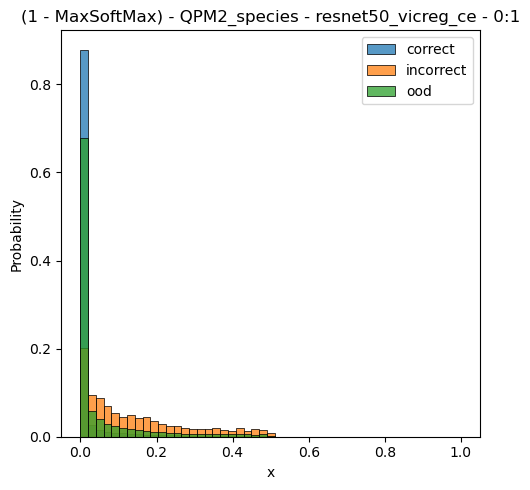

In [16]:
# plot (1 - maxsoftmax) of correct-ind, incorrect-ind, and ood data
ind_prob = np.exp(ind_lgt.astype(np.float64)) / np.exp(ind_lgt.astype(np.float64)).sum(-1, keepdims=True)
ind_pred = ind_prob.argmax(-1)
ind_ucty = -ind_prob.max(-1) + 1.0

if ood_str:
    ood_prob = np.exp(ood_lgt.astype(np.float64)) / np.exp(ood_lgt.astype(np.float64)).sum(-1, keepdims=True)
    ood_pred = ood_prob.argmax(-1)
    ood_ucty = -ood_prob.max(-1) + 1.0

df_t = pd.DataFrame({"x": ind_ucty[ind_pred == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty[ind_pred != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.linspace(0, 1, 50)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()